In [49]:
import pandas as pd
import seaborn as sns
import string
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import punkt 
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud
from spacy.lang.en import STOP_WORDS
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer,CountVectorizer,TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, mean_squared_error, accuracy_score, precision_score, recall_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer 
from graphviz import Digraph

**Load data**

In [50]:
data = pd.read_csv("../data/twitter-airline-sentiment/Tweets.csv")

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [52]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


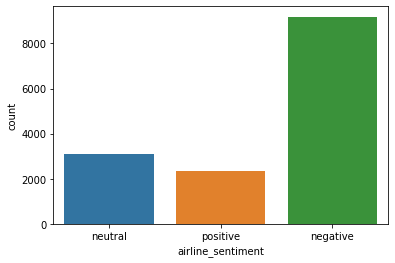

In [53]:
tweet = sns.countplot(data.airline_sentiment)

**Data Cleaning**

**Removing twitter @VirginAmerica from tweet column**

In [54]:
data['new_tweet'] = data.text.str.replace('@VirginAmerica', '')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,new_tweet
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),What @dhepburn said.
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus you've added commercials to the experien...
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),I didn't today... Must mean I need to take an...
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"it's really aggressive to blast obnoxious ""en..."
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and it's a really big bad thing about it


**Removing Special Characters(# and @)**

In [55]:
data['new_tweet'] = data['new_tweet'].str.replace("#", "")
data['new_tweet'] = data['new_tweet'].str.replace("@", "")
data['new_tweet'] = data['new_tweet'].str.replace("[^a-zA-Z#]", " ")
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,new_tweet
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),What dhepburn said
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus you ve added commercials to the experien...
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),I didn t today Must mean I need to take an...
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),it s really aggressive to blast obnoxious en...
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and it s a really big bad thing about it


In [56]:
data.new_tweet.head()

0                                  What dhepburn said 
1     plus you ve added commercials to the experien...
2     I didn t today    Must mean I need to take an...
3     it s really aggressive to blast obnoxious  en...
4             and it s a really big bad thing about it
Name: new_tweet, dtype: object

In [57]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
#import nltk
#nltk.download('wordnet')
#nltk.download('punkt')

def tokenize(text):
    #print(text)
    tokens = word_tokenize(text)
    #print(tokens)
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for tok in tokens:
        #print(tok)
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        #print(clean_tok)
        if clean_tok not in STOP_WORDS:
            clean_tokens.append(clean_tok)
        #print(clean_tokens)
    #tokens = [token.lower_ for token in text 
    #      if token.lower_ not in STOP_WORDS]
    return clean_tokens

In [58]:
data['tokenized_tweet'] = data['new_tweet'].apply(tokenize)

In [59]:
data['tokenized_tweet'].head()

0                                     [dhepburn, said]
1     [plus, ve, added, commercial, experience, tacky]
2                   [didn, t, today, mean, need, trip]
3    [s, aggressive, blast, obnoxious, entertainmen...
4                                 [s, big, bad, thing]
Name: tokenized_tweet, dtype: object

**create a word cloud which will depict the most common words in entire data set**

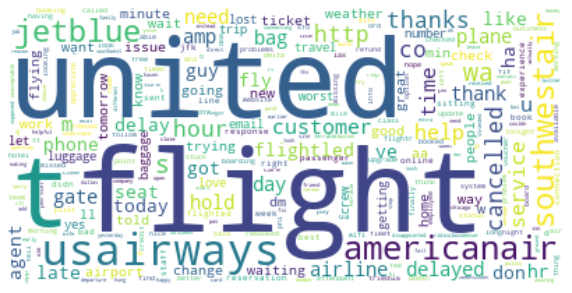

In [60]:
# get individual words
words = []
for line in data['tokenized_tweet']:
  words.extend(line)
 
# create a word frequency dictionary
wordfreq = Counter(words)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(
 background_color='white',
 max_words=2000,
 stopwords=stopwords
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Tweets which are labeled as positive**

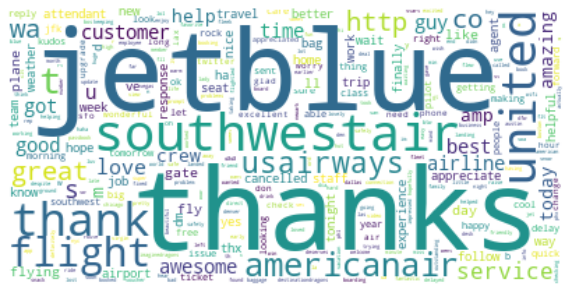

In [61]:
positive_words = []
for line in data.tokenized_tweet[data.airline_sentiment=='positive']:
 positive_words.extend(line)
 
# create a word frequency dictionary
poswordfreq = Counter(positive_words)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(
 background_color='white',
 max_words=2000,
 stopwords=stopwords
 ).generate_from_frequencies(poswordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Tweets which are labeled as negative**

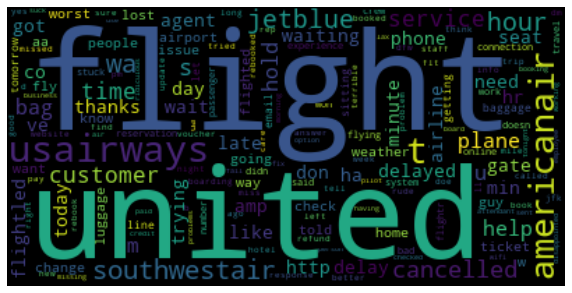

In [62]:
negative_words = []
for line in data.tokenized_tweet[data.airline_sentiment=='negative']:
   negative_words.extend(line)
 
# create a word frequency dictionary
negwordfreq = Counter(negative_words)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(
 background_color='black',
 max_words=2000,
 stopwords=stopwords
 ).generate_from_frequencies(negwordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [63]:
x_train, x_test, y_train, y_test = train_test_split(data['tokenized_tweet'].apply(lambda x: ' '.join(x)), 
      data['airline_sentiment'], test_size = 0.2, random_state = 42)

In [64]:
count_vect = CountVectorizer(lowercase=True, stop_words='english')
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

In [65]:
x_train_count = count_vect.fit_transform(x_train)
x_train_tfidf = transformer.fit_transform(x_train_count)

In [66]:
print(x_train_count.shape)
print(x_train_tfidf.shape)

(11712, 11170)
(11712, 11170)


In [67]:
x_test_count = count_vect.transform(x_test)
x_test_tfidf = transformer.transform(x_test_count)

In [68]:
print(x_test_count.shape)
print(x_test_tfidf.shape)

(2928, 11170)
(2928, 11170)


**Training our data with random forest classifier model.**

In [69]:
model = RandomForestClassifier(n_estimators=200)
model.fit(x_train_tfidf,y_train)
predictions = model.predict(x_test_tfidf)

**Confusion Matrix**

In [70]:
confusion_matrix(y_test,predictions)

array([[1766,   92,   31],
       [ 300,  227,   53],
       [ 157,   40,  262]], dtype=int64)

In [71]:
score = model.score(x_test_tfidf, y_test)
print("score of Random Forest Classifier is :" , score)

score of Random Forest Classifier is : 0.7701502732240437


**f1 score**

In [72]:
f1_score(y_test,predictions,average='weighted')

0.7519668962817252

In [73]:
f1_score(y_test,predictions,average='micro')

0.7701502732240437

In [74]:
f1_score(y_test,predictions,average='macro')

0.6644580570344417

**Accuracy score**

In [75]:
accuracy_score(y_test,predictions)*100

77.01502732240438

**Precision Score**

In [76]:
print("Precision Score : ",precision_score(y_test, predictions,average='weighted'))
print("Precision Score : ",recall_score(y_test, predictions,average='weighted'))

Precision Score :  0.7564789921413504
Precision Score :  0.7701502732240437


In [77]:
print("Precision Score : ",precision_score(y_test, predictions,average='micro'))
print("Precision Score : ",recall_score(y_test, predictions,average='micro'))

Precision Score :  0.7701502732240437
Precision Score :  0.7701502732240437


In [78]:
print("Precision Score : ",precision_score(y_test, predictions,average='macro'))
print("Precision Score : ",recall_score(y_test, predictions,average='macro'))

Precision Score :  0.727986454519526
Precision Score :  0.6323571979094629


**Using Extreme Gradient Classifier**

In [79]:
xg_reg = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 100)

In [80]:
xg_reg.fit(x_train_tfidf,y_train)
preds = xg_reg.predict(x_test_tfidf)

**The plot provide insight into how the model arrived at its final decisions and what splits it made to arrive at those decisions**

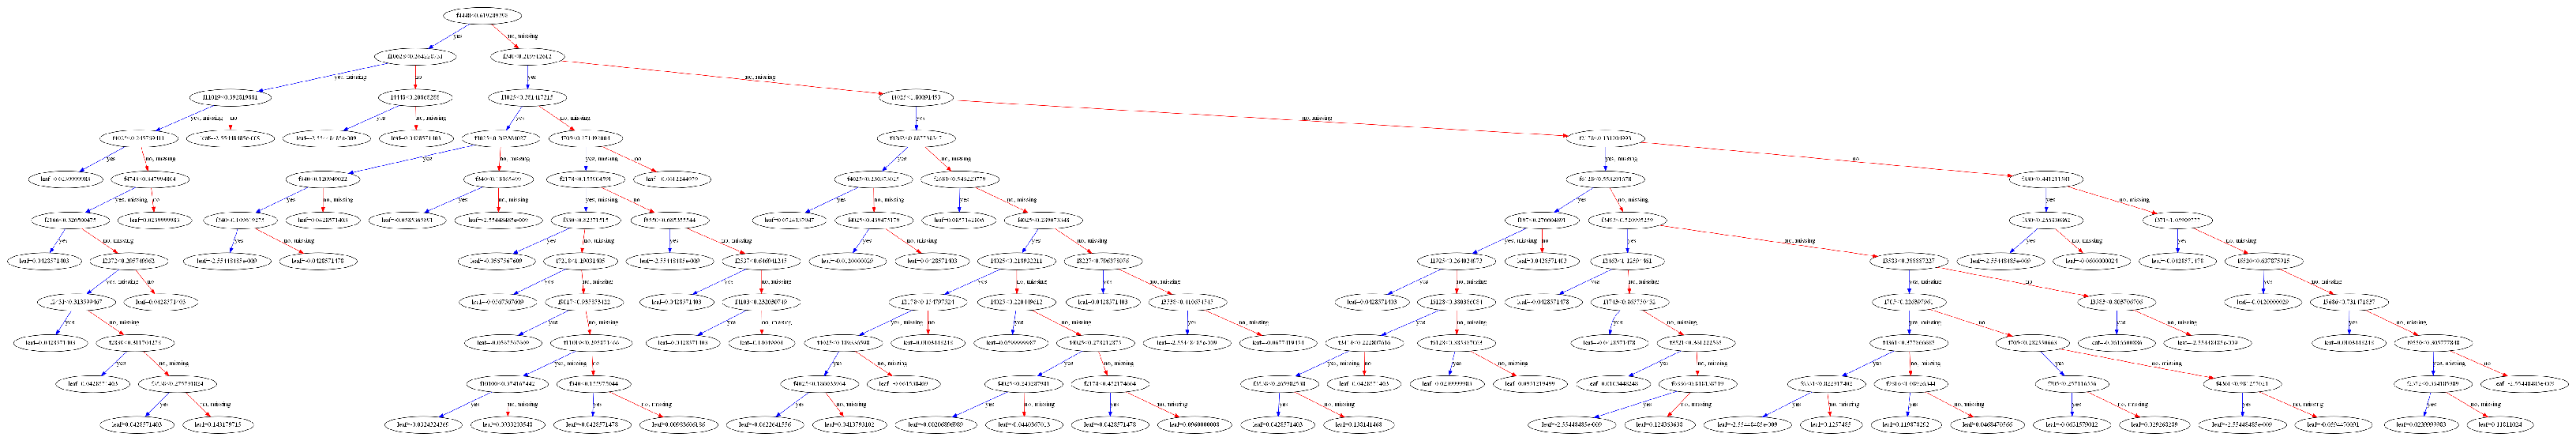

In [84]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

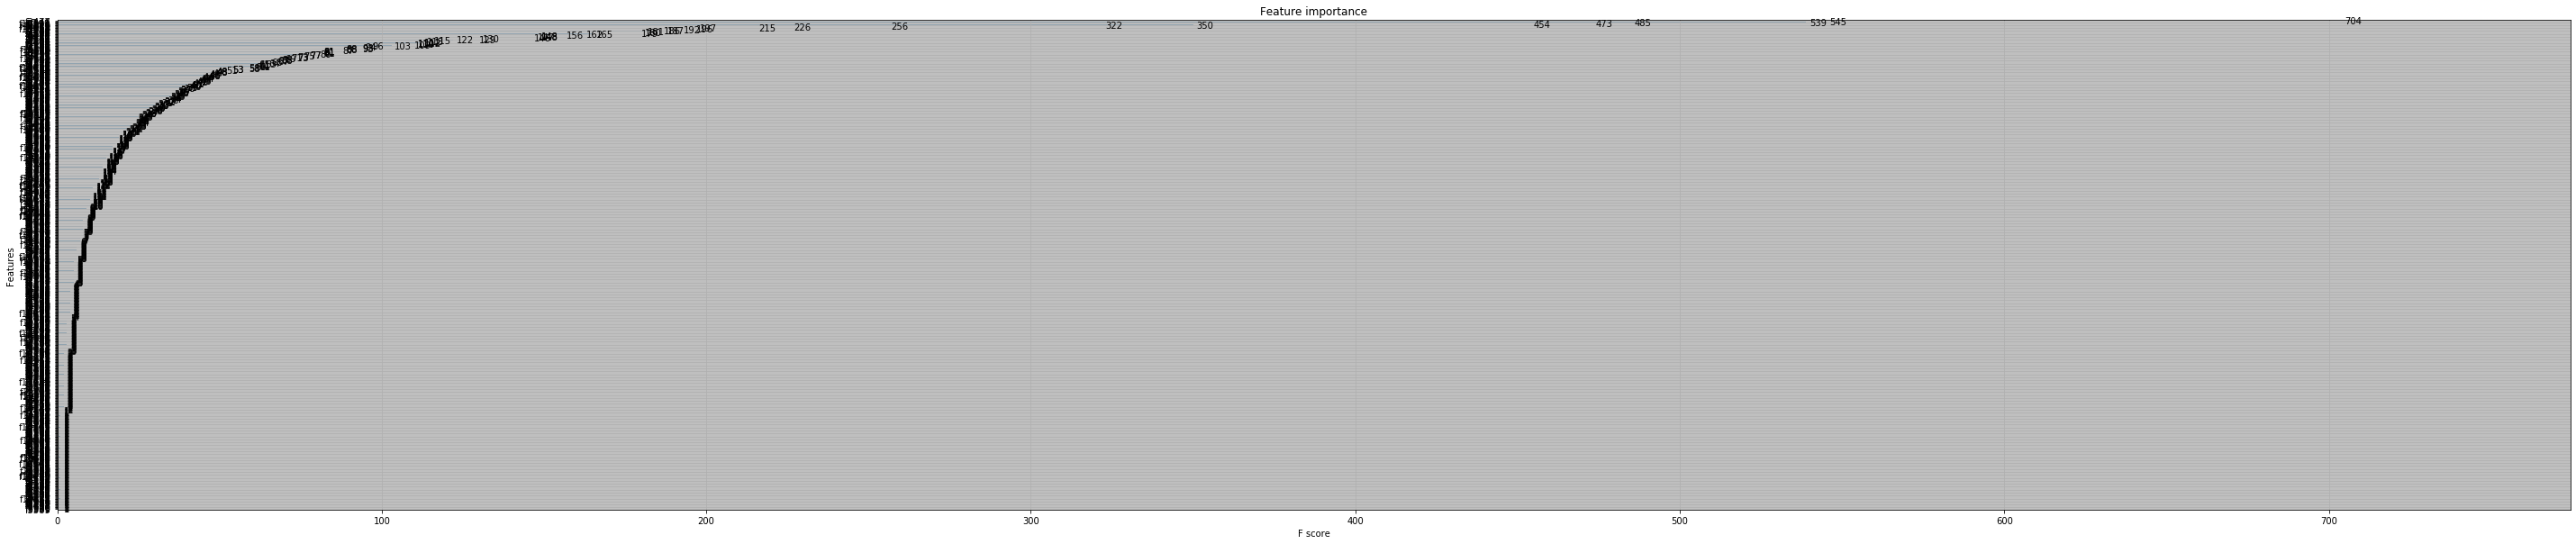

In [82]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

**Precision Score**

In [85]:
print("Precision Score : ",precision_score(y_test, preds,average='weighted'))
print("Precision Score : ",recall_score(y_test, preds,average='weighted'))

Precision Score :  0.7473433927825012
Precision Score :  0.7636612021857924


In [87]:
print("Precision Score : ",precision_score(y_test, preds,average='micro'))
print("Precision Score : ",recall_score(y_test, preds,average='micro'))

Precision Score :  0.7636612021857924
Precision Score :  0.7636612021857924


In [88]:
print("Precision Score : ",precision_score(y_test, preds,average='macro'))
print("Precision Score : ",recall_score(y_test, preds,average='macro'))

Precision Score :  0.7153498992743844
Precision Score :  0.6263854635179887


**Accuracy score**

In [89]:
accuracy_score(y_test,preds)*100

76.36612021857924

**f1 score**

In [90]:
f1_score(y_test,preds,average='weighted')

0.7441557252734654

In [91]:
f1_score(y_test,predictions,average='micro')

0.7701502732240437

In [92]:
f1_score(y_test,predictions,average='macro')

0.6644580570344417

**Confusion Matrix**

In [93]:
confusion_matrix(y_test,preds)

array([[1757,   88,   44],
       [ 327,  208,   45],
       [ 139,   49,  271]], dtype=int64)

In [94]:
score = xg_reg.score(x_test_tfidf, y_test)
print("score of Extreme Gradient Boost Classifier is :" , score)

score of Extreme Gradient Boost Classifier is : 0.7636612021857924
